# Data Import

In [44]:
import warnings
warnings.filterwarnings('ignore')

#statistical analysis
from scipy import stats

#database
from sqlalchemy import create_engine

#linear models and scoring
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn import linear_model #OLS model
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler

#optimization and metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error

#display module
from IPython.display import display_html

#stats and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#formatting
# pd.options.display.float_format = '{:.3f}'.format
# plt.style.use('dark_background')
pd.options.display.float_format = '{:20,.2f}'.format

#Load the houseprices data from Thinkful's database.
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()



In [45]:
# remove = ['None', '0']
# house_prices_df = house_prices_df.replace(to_replace=['None'], value=np.nan, regex=True)
# house_prices_df = house_prices_df.replace(to_replace=['0'], value=np.nan, regex=True)

#Helpers

Big thanks to Adam for the helper functions.  I found this a better method of controlling the technological debt incurred during this EDA process.

In [46]:
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)


def top_corrs(df, column, n=10):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(10)
    return top_n_num


def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()


def na_summary(df, group_col, additional_cols=None):
    if additional_cols is None:
        additional_cols = ["log_saleprice"]

    additional_cols.append(group_col)
    # fmt: off
    df = (
      df[additional_cols]
        .fillna("NaN")
        .groupby(group_col)
        .agg(["size", "mean", "sum"])
    )
    display(df)
    # fmt: on


def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")
    

#Data Inspection

In [47]:
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns
numeric_columns = house_prices_df.select_dtypes(['int64', 'float64']).columns
numeric = house_prices_df.select_dtypes(['int64', 'float64'])
non_numeric = house_prices_df.select_dtypes(['object'])


print(f'The number of non-numerical columns: {(len(non_numeric_columns))}\nThe number of numerical columns: {(len(numeric_columns))}\nThe Dataset contains {(house_prices_df.shape[0])} rows and {(house_prices_df.shape[1])} columns')

The number of non-numerical columns: 43
The number of numerical columns: 38
The Dataset contains 1460 rows and 81 columns


Initial observations: the numbers indicate the my model's feed-in dataset should benefit from around 8 features.   

In [48]:
house_prices_df.describe(include=[np.number])

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,"1,460.00","1,460.00","1,201.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,452.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,379.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00"
mean,730.50,56.90,70.05,"10,516.83",6.10,5.58,"1,971.27","1,984.87",103.69,443.64,46.55,567.24,"1,057.43","1,162.63",346.99,5.84,"1,515.46",0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,"1,978.51",1.77,472.98,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,"2,007.82","180,921.20"
std,421.61,42.30,24.28,"9,981.26",1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,213.80,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,"79,442.50"
min,1.00,20.00,21.00,"1,300.00",1.00,1.00,"1,872.00","1,950.00",0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,"1,900.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,"2,006.00","34,900.00"
25%,365.75,20.00,59.00,"7,553.50",5.00,5.00,"1,954.00","1,967.00",0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,"1,129.50",0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,"1,961.00",1.00,334.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,"2,007.00","129,975.00"
50%,730.50,50.00,69.00,"9,478.50",6.00,5.00,"1,973.00","1,994.00",0.00,383.50,0.00,477.50,991.50,"1,087.00",0.00,0.00,"1,464.00",0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,"1,980.00",2.00,480.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,"2,008.00","163,000.00"
75%,"1,095.25",70.00,80.00,"11,601.50",7.00,6.00,"2,000.00","2,004.00",166.00,712.25,0.00,808.00,"1,298.25","1,391.25",728.00,0.00,"1,776.75",1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,"2,002.00",2.00,576.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,"2,009.00","214,000.00"
max,"1,460.00",190.00,313.00,"215,245.00",10.00,9.00,"2,010.00","2,010.00","1,600.00","5,644.00","1,474.00","2,336.00","6,110.00","4,692.00","2,065.00",572.00,"5,642.00",3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,"2,010.00",4.00,"1,418.00",857.00,547.00,552.00,508.00,480.00,738.00,"15,500.00",12.00,"2,010.00","755,000.00"


In [49]:
house_prices_df.describe(include=[np.object])

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfintype2,heating,heatingqc,centralair,electrical,kitchenqual,functional,fireplacequ,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [50]:
for column in house_prices_df:
    for value in house_prices_df[column]:
        if value in house_prices_df[column] is object:
            house_prices_df[column] = house_prices_df[column].apply(str.strip).replace("", np.nan)

questionable float values at: lotfrontage: 75.0
there are missing values that are floats


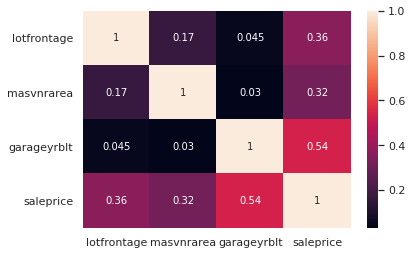

In [51]:
ints = house_prices_df.select_dtypes(['int64'])
floats = house_prices_df.select_dtypes(['float64'])

for column in ints:
    for value in ints[column]:
        try: 
            float(value)
        except: 
            print(f' questionable int value: {column}')
        break
        print(ints.isna().sum().any())
        if ints.isna().sum().any() == None:
                pass
for column in floats:
    for value in floats[column]:
        try: 
            float(value)
        except:
             if value != None:
                 break
    else: 
            print(f'questionable float values at: {column}: {value}')
    break
else:
        print(floats.isna().sum().any())
if floats.isna().sum().any() != None:
    try:
        print(f"there are missing values that are floats")
    except:
        raise(StopIteration)

#let's see the issue
#i'm anticipating here
sns.heatmap(abs(np.log(house_prices_df[['lotfrontage', 'masvnrarea', 'garageyrblt', 'saleprice']])).corr(), annot=True);

#drop low corr floats
# house_prices_df = house_prices_df.drop(columns=['id', 'lotfrontage', 'masvnrarea'])

In [52]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [53]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

NotAllowedError: The request is not allowed by the user agent or the platform in the current context.


In [54]:
cols = floats.columns 
for cols in house_prices_df[cols]:
    house_prices_df[cols].fillna(house_prices_df[cols].mean(), inplace=True)

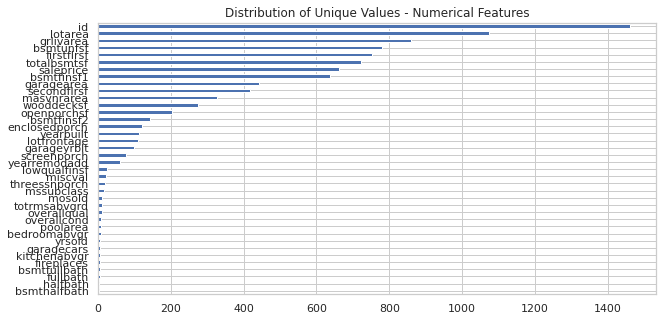

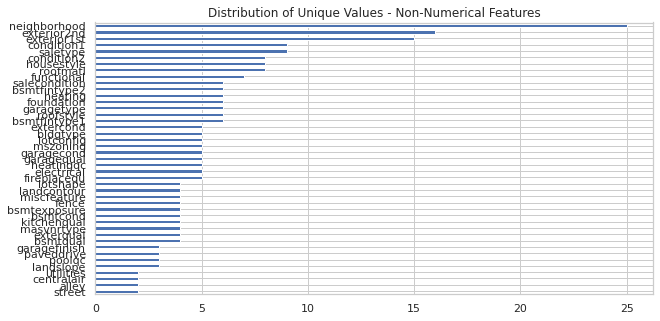

In [55]:
numeric_df = house_prices_df.select_dtypes(['int64', 'float64'])
non_numeric_df = house_prices_df.select_dtypes(['object'])

plt.figure(figsize=(10,5))
numeric_df.nunique().sort_values(ascending=True).plot(kind='barh')
plt.title("Distribution of Unique Values - Numerical Features");

plt.figure(figsize=(10,5))
non_numeric_df.nunique().sort_values(ascending=True).plot(kind='barh')
plt.title("Distribution of Unique Values - Non-Numerical Features");

visualizing the bins of unique data to scout for categories, if any, and any other gaps.

# Missing Values

In [56]:
pd.set_option('use_inf_as_na', True) #to ensure everything comes up for missing vals check

percent_missing = (house_prices_df.isna().sum()/(len(house_prices_df)/ 100))
percent_missing = percent_missing.to_frame().reset_index()
percent_missing = percent_missing.rename(columns= {0: 'percentage', 'index': 'Name'}).sort_values(by='percentage', ascending=False)
percent_missing.index.name = 'index'
display(print(# number of cols missing values
percent_missing[percent_missing['percentage'] > 0.00]))
# number of cols missing values
percent_missing[percent_missing['percentage'] > 0.00].count()

               Name           percentage
index                                   
72           poolqc                99.52
74      miscfeature                96.30
6             alley                93.77
73            fence                80.75
57      fireplacequ                47.26
60     garagefinish                 5.55
58       garagetype                 5.55
63       garagequal                 5.55
64       garagecond                 5.55
32     bsmtexposure                 2.60
35     bsmtfintype2                 2.60
33     bsmtfintype1                 2.53
31         bsmtcond                 2.53
30         bsmtqual                 2.53
25       masvnrtype                 0.55
42       electrical                 0.07


None

Name          16
percentage    16
dtype: int64

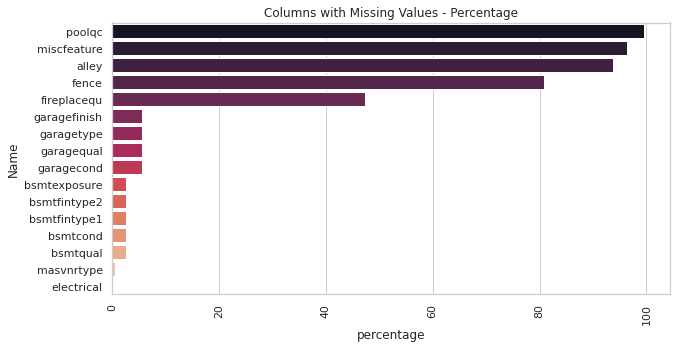

In [57]:
#visualize
data = percent_missing[percent_missing['percentage'] > 0.00]
plt.figure(figsize=(10,5))
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'percentage', y = 'Name', data=data, palette='rocket')
plt.xticks(rotation = 90)
plt.title('Columns with Missing Values - Percentage')
plt.show()


### INFERENCE: If the missing values were visualized in 3D, we could see how the density of the higest missing values could highly skew the model results.  Initially, I proposed imputing all the values and working ground-up, however, removing dead-weight is the better option. 

# handling missing values - most to least

In [58]:
#create shallow copy
house_prices_df_copy = house_prices_df.copy()

cols = list(percent_missing['Name'].values)

for cols in house_prices_df[cols]:
    if house_prices_df[(house_prices_df[cols].notnull()) & (house_prices_df['saleprice'].notnull())] is None:
        print(cols)

In [59]:
#logically examine if...then that...
house_prices_df[house_prices_df['poolqc'].isna()]
house_prices_df[house_prices_df['miscfeature'].isna()].isna().sum().sort_values(ascending=False)
house_prices_df[house_prices_df['miscfeature'].isna() != 'None']
house_prices_df[house_prices_df['alley'] != 'None']

#if we kept nonnulls and non nulls target vals, is there good info?
house_prices_df[(house_prices_df['poolqc'].notnull()) & (house_prices_df['saleprice'].notnull())] 
del house_prices_df['poolqc']
house_prices_df[(house_prices_df['miscfeature'].notnull()) & (house_prices_df['saleprice'].notnull())].dropna(inplace=True)
del house_prices_df['miscfeature']
house_prices_df[(house_prices_df['alley'].notnull()) & (house_prices_df['saleprice'].notnull())].dropna(inplace=True) # note: garageyr needs to be datetime
del house_prices_df['alley']
house_prices_df[(house_prices_df['fence'].notnull()) & (house_prices_df['saleprice'].notnull())]
del house_prices_df['fence']
house_prices_df[(house_prices_df['fireplacequ'].notnull()) & (house_prices_df['saleprice'].notnull())] # why is lotfrontage continous and lotarea discrete? #yearbuilt better distru
# del house_prices_df['fireplacequ']
house_prices_df['lotarea'] = house_prices_df['lotarea'].astype(float)
del house_prices_df['lotfrontage']
del house_prices_df['fireplacequ']
# house_prices_df['fireplaces'] convert bools to int
house_prices_df['fireplaces'].replace({False: 0, True: 1}, inplace=True)

In [60]:
import math
81-75

6

after examining features with the most missing values, the columns were dropped. Some were dependent on other columns and filling the values in would be useless.

In [61]:
house_prices_df.shape

(1460, 75)

Our df now has 75 columns

In [62]:
numeric_columns = house_prices_df.select_dtypes(['int64', 'float64']).columns
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns
(house_prices_df.isna().sum()/(len(house_prices_df)/ 100)).sort_values(ascending=False)
house_prices_df['garagetype'].interpolate(method='pad', inplace=True)
house_prices_df['garagefinish'].interpolate(method='pad', inplace=True)
house_prices_df['garagecond'].interpolate(method='pad', inplace=True)
house_prices_df['garagequal'].interpolate(method='pad', inplace=True)
house_prices_df['bsmtfintype2'].interpolate(method='pad', inplace=True)

Features above weren't missing too many values compared to size of df.  Interpolation was used to fill missing values. 


In [63]:
house_prices_df.shape
house_prices_df.isna().sum().sort_values(ascending=False)
house_prices_df = house_prices_df.interpolate(method='pad')

To handle the remaining missing values, interpolate was also used.  Given the features were related to the features above, using the same method saves time.

In [64]:
house_prices_df.head()

,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,"8,450.00",Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,"2,003.00",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,"9,600.00",Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,"1,976.00",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,"11,250.00",Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,"2,001.00",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,"9,550.00",Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,"1,998.00",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,"14,260.00",Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,"2,000.00",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [65]:
# drop id col 
del house_prices_df['id']

In [66]:
house_prices_df.shape

(1460, 74)

In [67]:
# house_prices_df = pd.get_dummies(house_prices_df.select_dtypes(['object']),drop_first=True)


In [68]:
# del house_prices_df['id']
# house_prices_df.index = house_prices_df['id']
# house_prices_df.head()

I would love to dummy these, but it's extraneous - divisng a plan to handle these without a partner is a bad business decision.  An expert in ML may have better input.

## Provide explaination for missing values

Observations:
    * where poolqc is blank, poolarea is 0.  
    * where miscfeeature is blank, miscval is None
    * where fence is blank, pool was blank
    * fireplacequal is a boolean and dependent on fireplaces

    columns with high missing values (>50%):
        drop for leverage
    for categorical columns:
        convert to dummy variables
    for numerical columns:
        apply log transform
        interpolate - akima



#Distribution of Target Variable

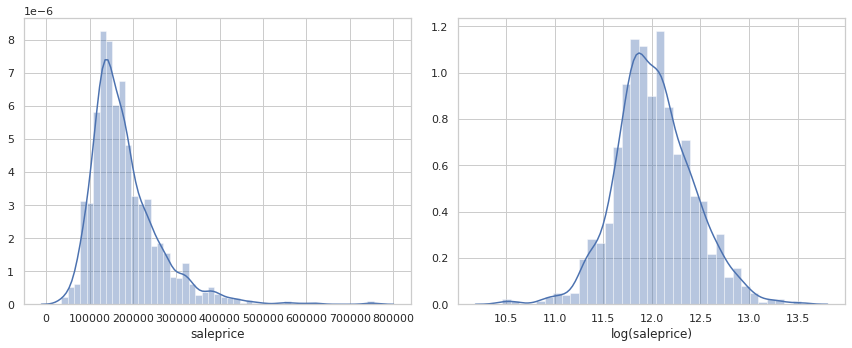

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.distplot(house_prices_df["saleprice"], ax=axes[0])
sns.distplot(np.log(house_prices_df["saleprice"]), ax=axes[1])
axes[1].set_xlabel("log(saleprice)")
plt.tight_layout()
plt.show()



With right skewing and kurtosis, the target varible improves after log transformation.  Judging the shape of the transformed values, I anticipate dropping as many features as possible.  

#Distribution of Independent Variables

## Numeric columns: 

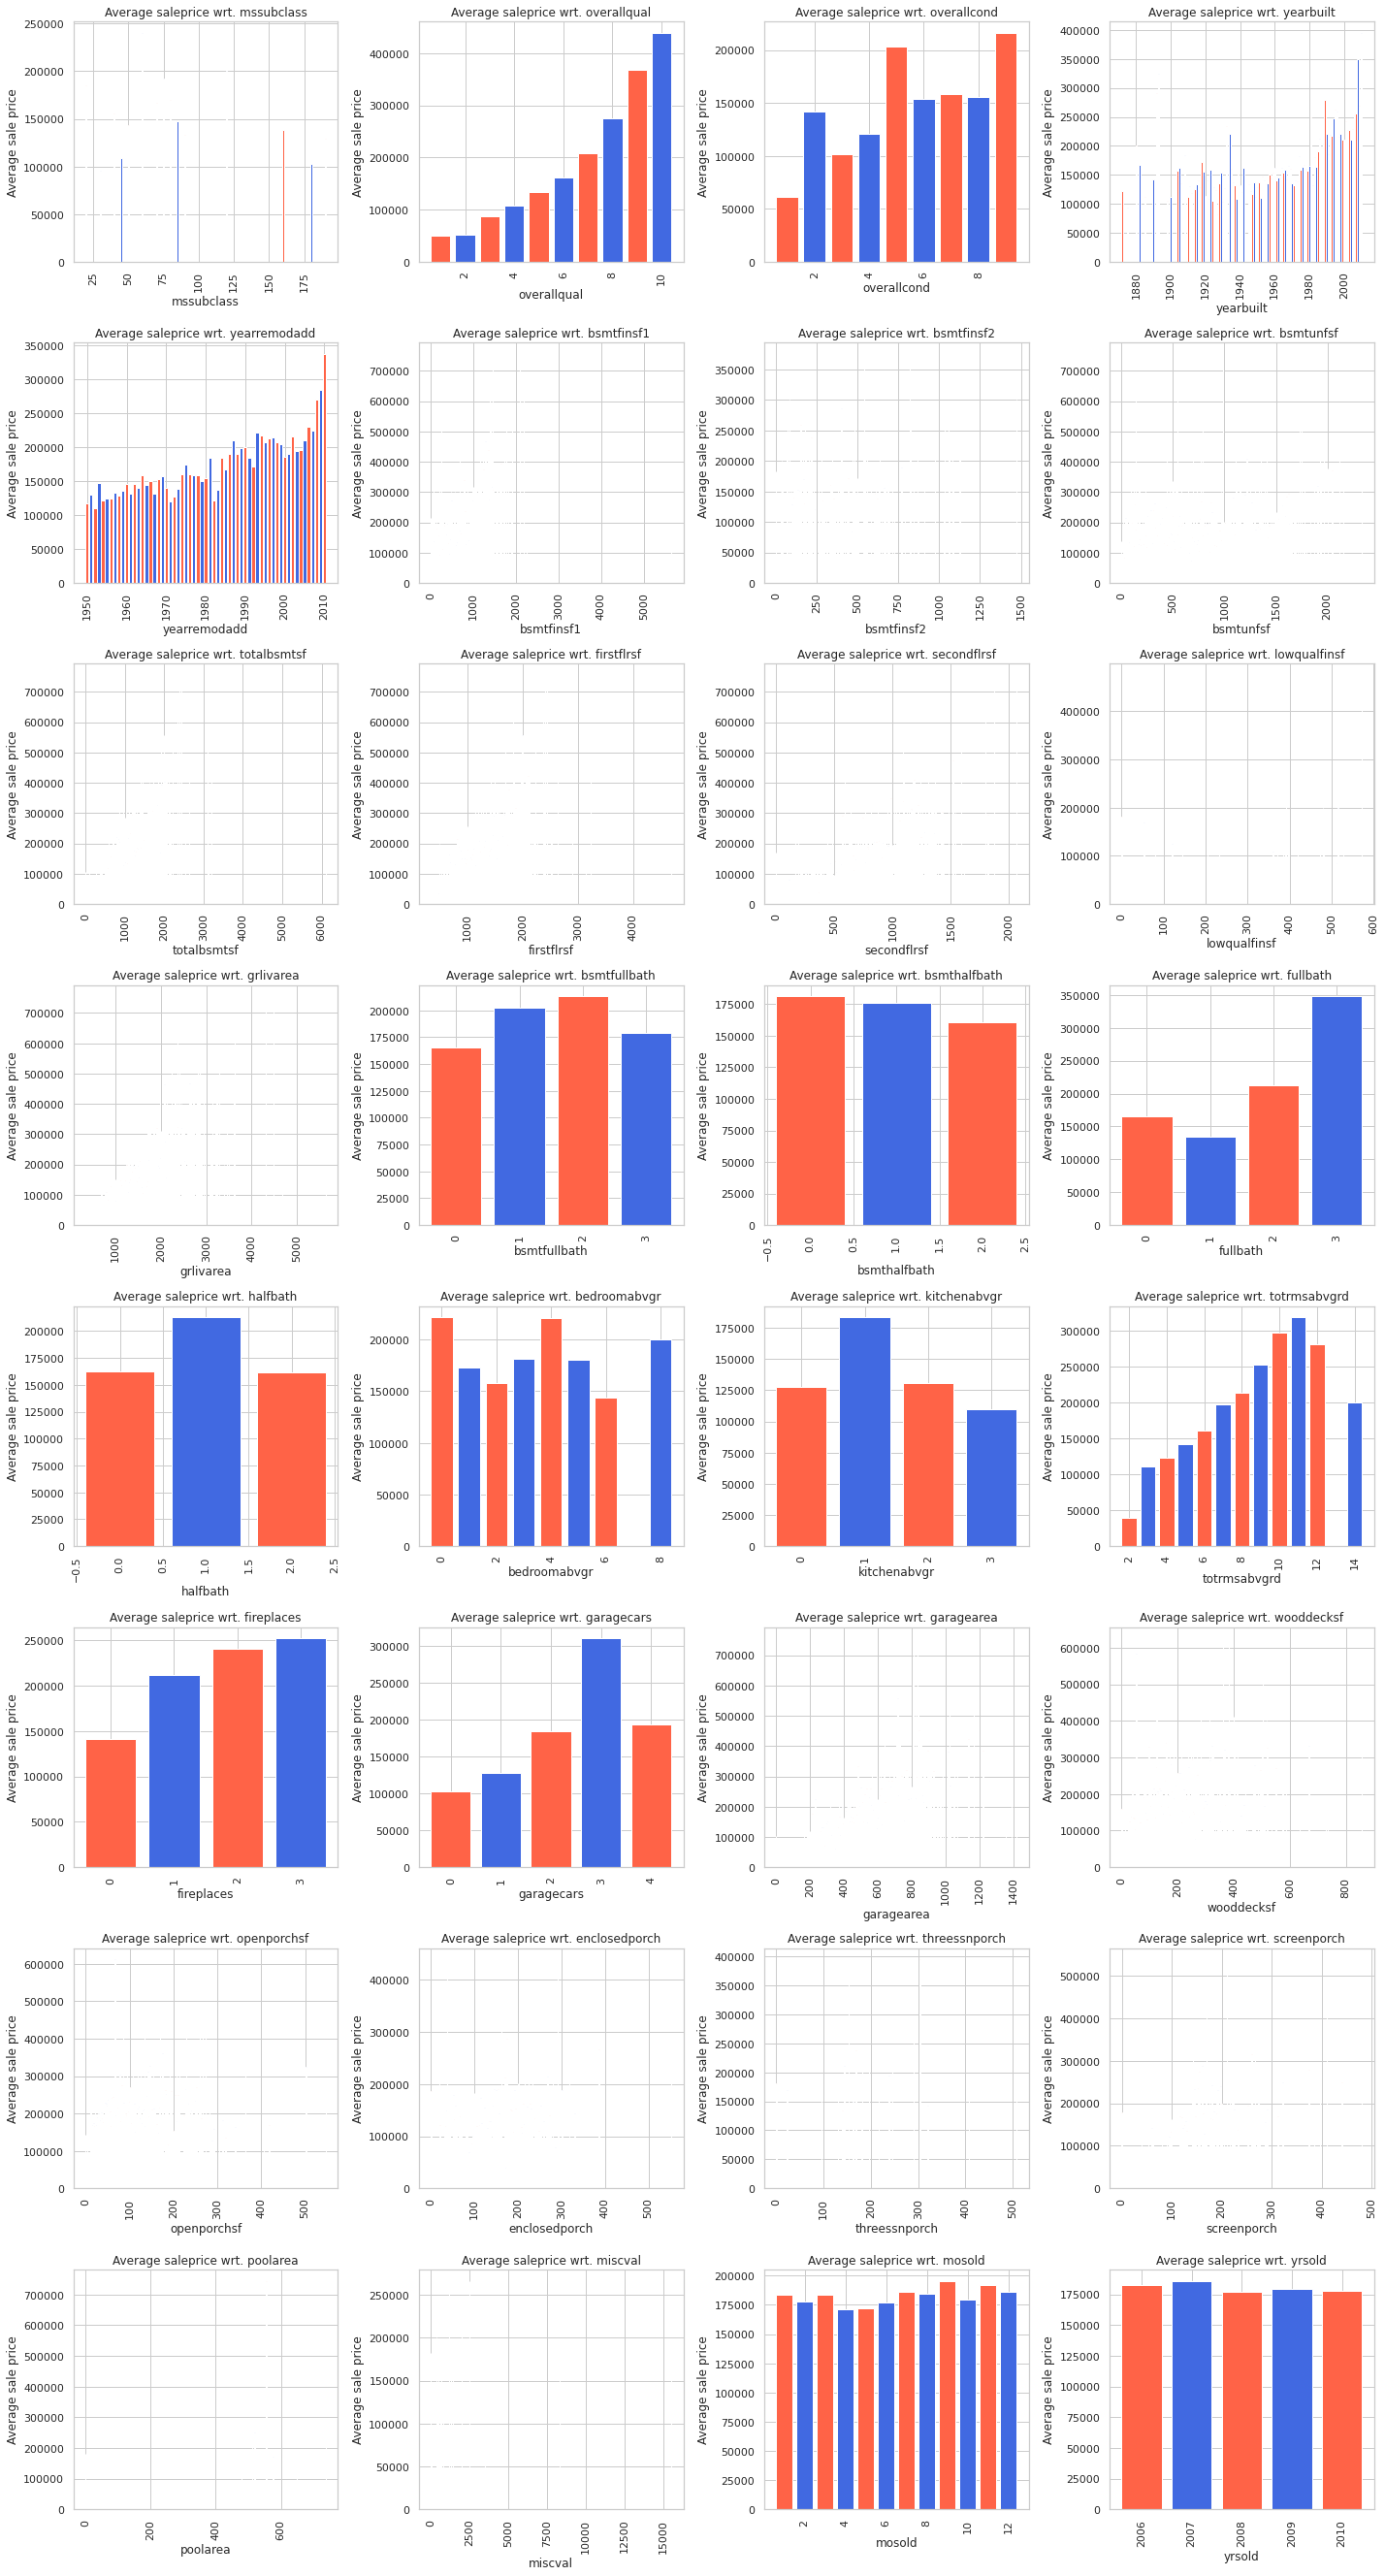

In [70]:
numeric_columns = [col_name for col_name in house_prices_df.dtypes[house_prices_df.dtypes.values == 'int64'].index 
                    if col_name not in ["id", "saleprice"] ]

plt.figure(figsize=(20,50))
for index, column in enumerate(numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df.groupby(column)["saleprice"].mean().index, 
            house_prices_df.groupby(column)["saleprice"].mean(),
           color=("tomato","royalblue"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

## Non numeric

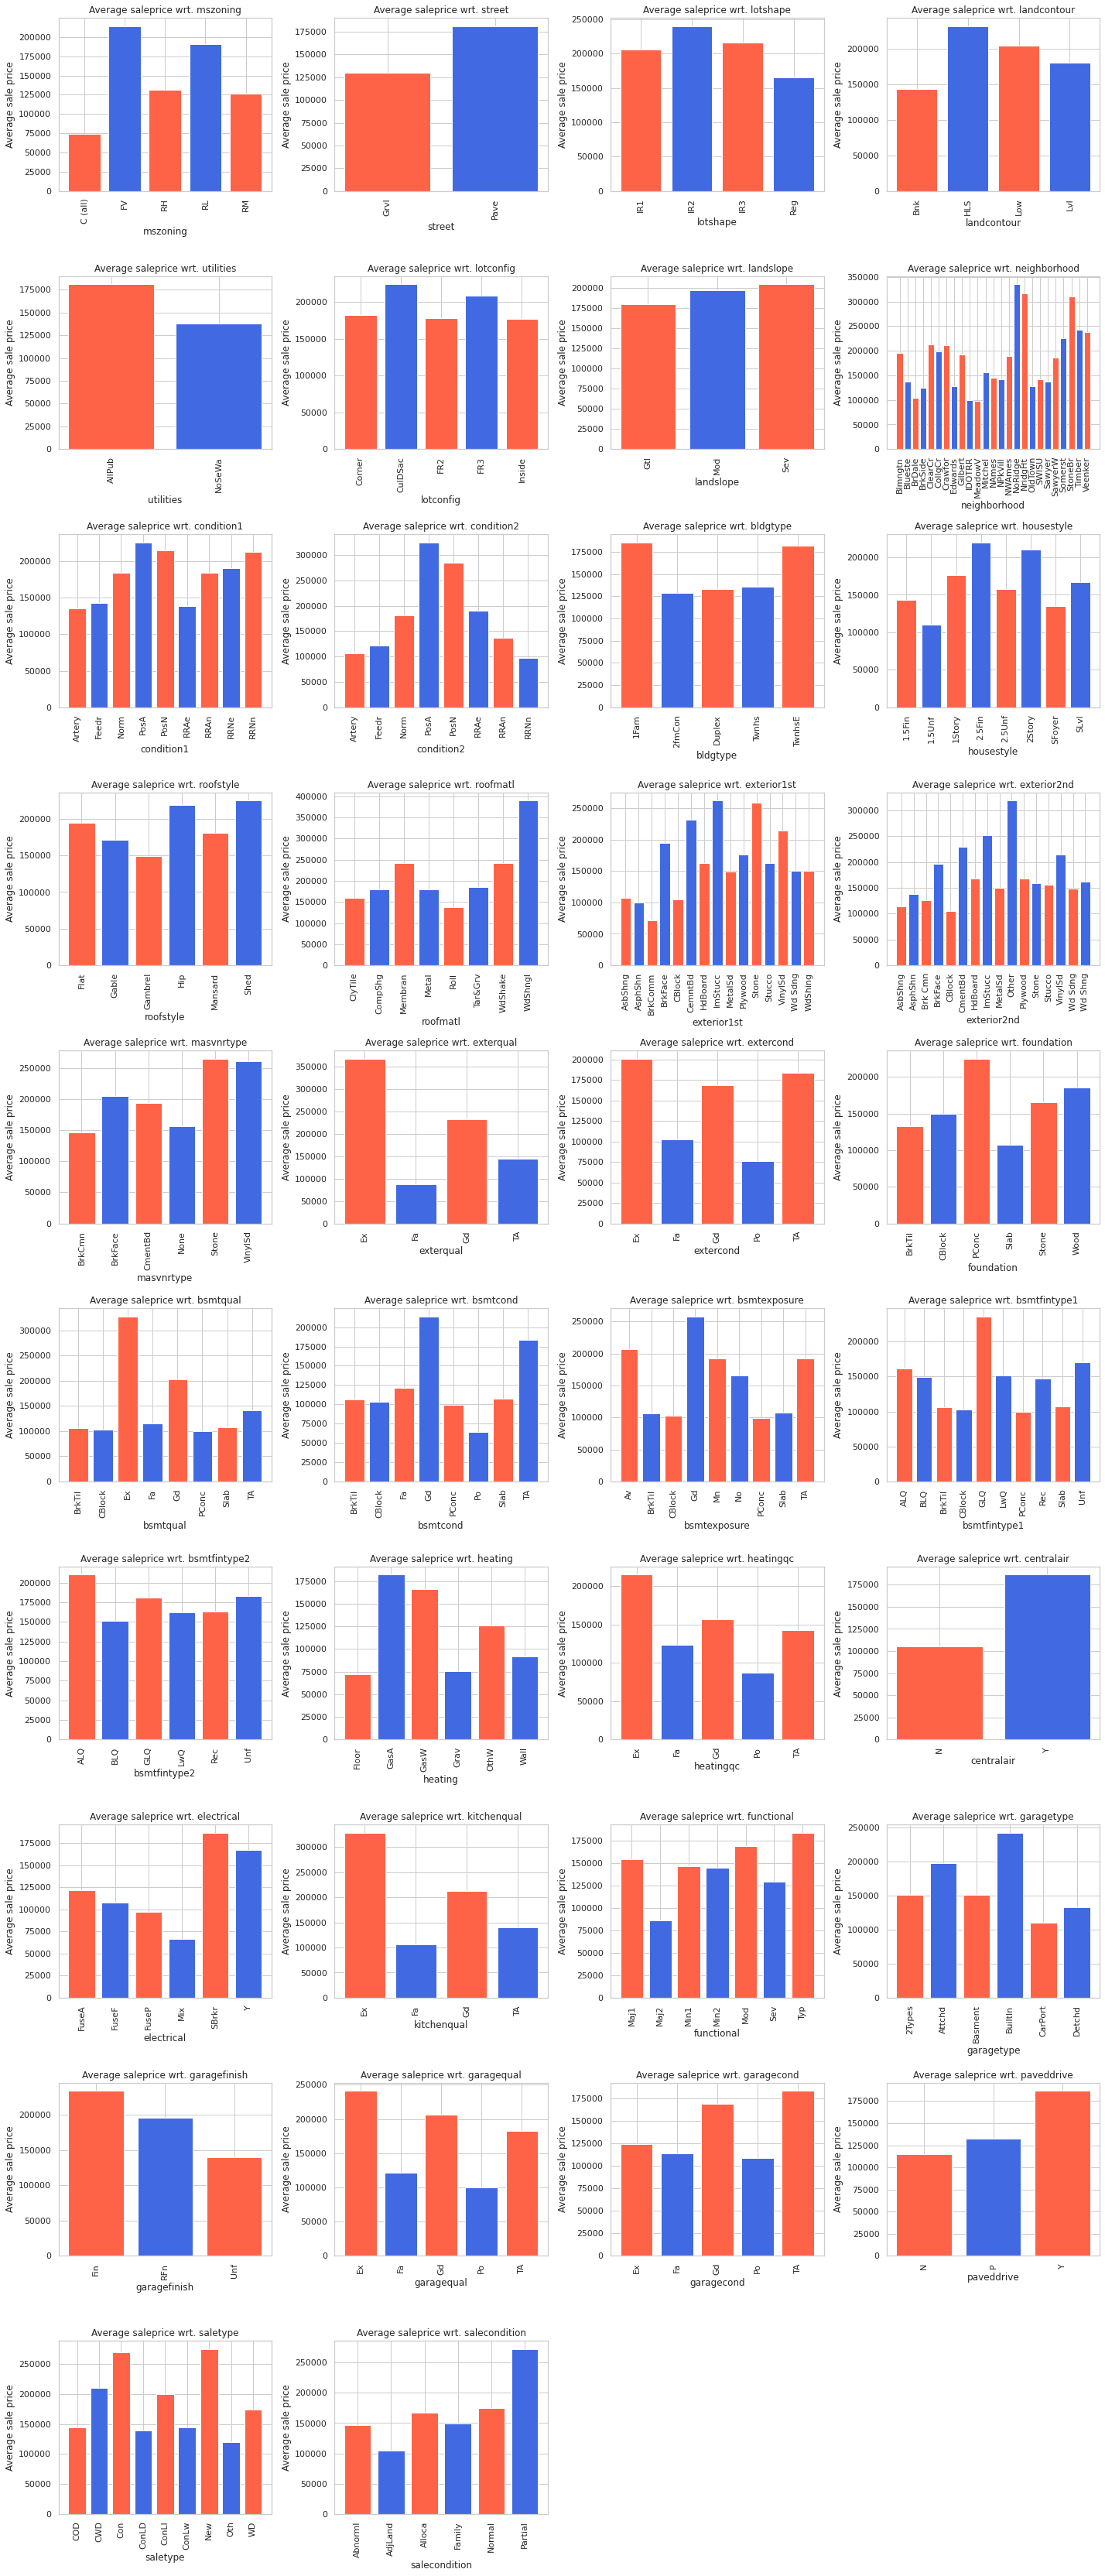

In [71]:
plt.figure(figsize=(20,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df.groupby(column)["saleprice"].mean().index, 
            house_prices_df.groupby(column)["saleprice"].mean(),
           color=("tomato","royalblue"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

### We anticipate dropping the features with poor distributions, class imbalances and high subjectivity.  

# Correlations

In [72]:
log_df = house_prices_df.copy()
log_df["log_saleprice"] = np.log(log_df["saleprice"])
log_df = log_df.drop(columns=["saleprice"])

top_n_corrs = top_corrs(house_prices_df, "saleprice")
log_top_n_corrs = top_corrs(log_df, "log_saleprice")

display_side_by_side(top_n_corrs, log_top_n_corrs)



,corr,abs_corr
saleprice,1.00,1.00
overallqual,0.79,0.79
grlivarea,0.71,0.71
garagecars,0.64,0.64
garagearea,0.62,0.62
totalbsmtsf,0.61,0.61
firstflrsf,0.61,0.61
fullbath,0.56,0.56
totrmsabvgrd,0.53,0.53
yearbuilt,0.52,0.52


The correlation index aligns with intepretation of the distribution of the target variable.  

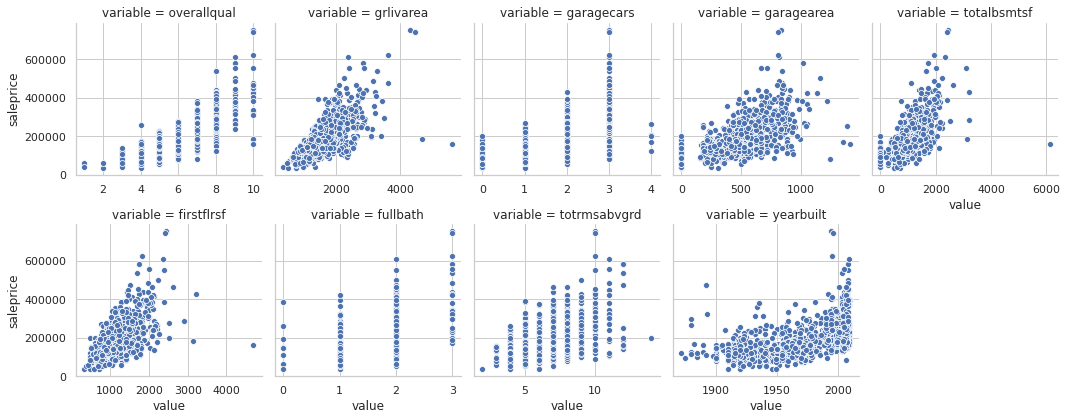

In [73]:
plot_top_corrs(house_prices_df, "saleprice")

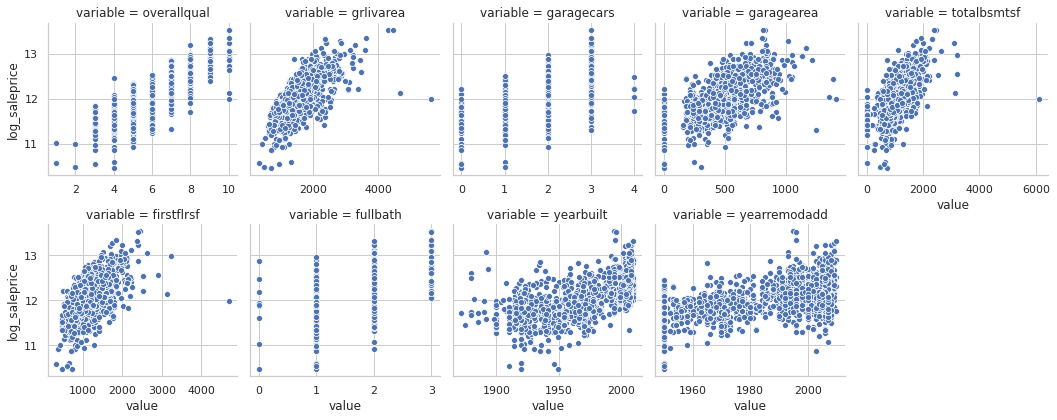

In [74]:
plot_top_corrs(log_df, "log_saleprice")

We will use the 9 most correlated features (those features that stratify well). Insturctor recommends this.  Prior methods attempted, however, leverage toward target variable lost. 

Numerical variables provide more leverage at target variable.


# Z scores

In [75]:
target = house_prices_df['saleprice']
log_target = np.log(house_prices_df['saleprice'])

#check for outliers
#should be clear 
from scipy.stats import zscore
z_scores = zscore(target)
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


z_scores = zscore(log_target)
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
The indices of the outliers:
(array([   6,   11,   13,   20,   27,   34,   35,   45,   53,   58,   65,
        113,  119,  152,  158,  160,  162,  168,  179,  186,  190,  191,
        197,  200,  209,  219,  225,  227,  232,  239,  241,  250,  262,
        271,  273,  279,  302,  305,  306,  310,  314,  318,  321,  322,
        323,  327,  333,  337,  344,  350,  351,  360,  378,  379,  390,
        409,  410,  424,  427,  441,  452,  461,  474,  478,  479,  481,
        482,  497,  504,  516,  518,  524,  527,  539,  540,  549,  554,
        564,  566,  568,  583,  585,  591,  595,  600,  608,  610,  612,
        618,  619,  639,  640,  642,  644,  654,  661,  664,  678,  683,
        688,  691,  692,  700,  702,  706,  718,  720,  724,  745,  747,
        748,  753,  759,  763,  764,  765,  769,  774,  792,  798,  803,
        817,  825,  875,  877,  885,  888,  898,  926,  932,  947,  961,
        981,  987,  990,  994, 1024, 1027, 1032, 1036, 1037, 1043, 1

Z scores indicate the number of outliers increases at min. threshold after log transformation. Outliers decrease in transformed variable with increased threshold. 



---



---



#Feature Engineering

In [76]:
log_df = house_prices_df.copy()

#define df w/features
model_df = log_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt']]
model_df = np.log(model_df)
#handling missing values
#use polynomial in lieu of akima
model_df = model_df.interpolate(method='nearest', order=2)


In [77]:
#normalize
X = StandardScaler().fit_transform(model_df)
# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[1.0006854  0.60155975 0.48767253 0.43952789 0.42489279 0.43154762
  0.52135101 0.42690499 0.5538099 ]
 [0.60155975 1.0006854  0.45386741 0.42446943 0.41535937 0.54635802
  0.65104424 0.82825714 0.23309108]
 [0.48767253 0.45386741 1.0006854  0.85374104 0.40050294 0.40210588
  0.5201624  0.34215861 0.5029199 ]
 [0.43952789 0.42446943 0.85374104 1.0006854  0.4373983  0.44330248
  0.44164083 0.30904163 0.45615509]
 [0.42489279 0.41535937 0.40050294 0.4373983  1.0006854  0.81988749
  0.35040486 0.2920888  0.39498241]
 [0.43154762 0.54635802 0.40210588 0.44330248 0.81988749 1.0006854
  0.37390817 0.41498312 0.27721526]
 [0.52135101 0.65104424 0.5201624  0.44164083 0.35040486 0.37390817
  1.0006854  0.54195733 0.48963603]
 [0.42690499 0.82825714 0.34215861 0.30904163 0.2920888  0.41498312
  0.54195733 1.0006854  0.10573803]
 [0.5538099  0.23309108 0.5029199  0.45615509 0.39498241 0.27721526
  0.48963603 0.10573803 1.0006854 ]]


In [78]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[0.34638675 0.36861337 0.35336368 0.34191286 0.31857908 0.33311612
 0.34747881 0.30356817 0.27751752]
Eigenvalue 1: 4.718817063630275
----------------------------------------
Eigenvector 2: 
[ 0.02569814 -0.4495421   0.33028467  0.34544272  0.08709232 -0.08001629
 -0.10914098 -0.56645698  0.47123234]
Eigenvalue 2: 1.2808287604829391
----------------------------------------
Eigenvector 3: 
[ 0.14050206  0.1132253   0.20658043  0.10165962 -0.63122816 -0.6030449
  0.316367    0.16104017  0.16215699]
Eigenvalue 3: 1.0617662234449645
----------------------------------------
Eigenvector 4: 
[ 0.43286463 -0.02456638 -0.44223267 -0.52750397  0.09533119 -0.03238999
  0.1994697  -0.12528863  0.52208427]
Eigenvalue 4: 0.7786182124925044
----------------------------------------
Eigenvector 5: 
[ 0.69843331  0.09915117  0.04299373  0.0958671  -0.12834826 -0.04251253
 -0.66852579  0.01801457 -0.16059   ]
Eigenvalue 5: 0.4567331550806893
----------------------------------------
Eigenv

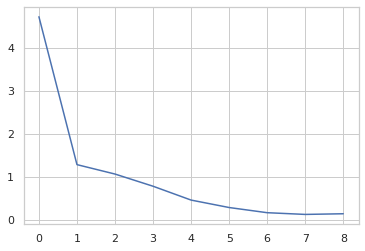

[4.71881706 1.28082876 1.06176622 0.77861821 0.45673316 0.28360634
 0.16339284 0.12347033 0.13893568]


In [79]:
#choosing components
#print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

Observations with by-hand method: 
The scree plot and eigenvalues inform keeping the 1st of the 9 components.

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.52395389 0.14221683 0.11789322 0.08645388 0.05071337]


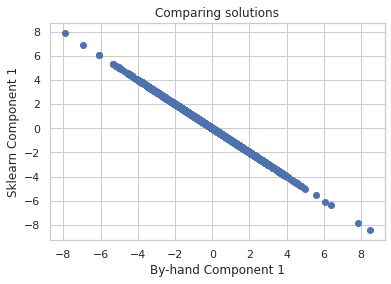

In [80]:
sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

Our sklearn method confirms our prior conclusion with additional insight. 

While the 1st component accounts for most variance, trimming them down to 4 offers best solution.

#Modeling

OLS model

In [81]:
X = log_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf']]
log_df["log_saleprice"] = np.log(log_df["saleprice"])

y = log_df["log_saleprice"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('There are {:d} training samples and {:d} test samples'.format(X_train.shape[0], X_test.shape[0]))

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()

There are 1168 training samples and 292 test samples


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     1965.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:12:22   Log-Likelihood:                -1708.4
No. Observations:                1460   AIC:                             3429.
Df Residuals:                    1454   BIC:                             3460.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -7.5010      0.093    -80.503      0.000      -7.684      -7.318
overallqual     0.3772      0.022     17.506      0.000       0.335       0.419
grlivarea       0.0015      5e-05     30.222      0.000       0.001       0.002
garagecars      0.8228      0.061     13.550      0.000       0.704       0.942
garagearea      0.0005      0.000      2.278      0.023    6.66e-05       0.001
totalbsmtsf     0.0012   5.83e-05     19.942      0.000       0.001       0.001
==============================================================================
Omnibus:                      163.598   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1421.873
Skew:                           0.025   Prob(JB):                    1.76e-309
Kurtosis:                       7.834   Cond. No.                     9.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our models indicate strong multicollinearity.  Check VIF scores:

In [82]:
# print_vif(X)

Our VIF results indicate there's colinearity between the garage terms, at most.  We could combine to make a ratio.

In [83]:
# X.head()
# X['garage_ratio'] = (X['garagecars']/X['garagearea']) * 100
# X.head()
# X = X.interpolate(method='ffill')
# print_vif(X)

after combining the garage terms for a ratio, multicolinear decreases. 

Linear Model

In [84]:
X = log_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf']]
log_df["log_saleprice"] = np.log(log_df["saleprice"])
y = log_df["log_saleprice"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('There are {:d} training samples and {:d} test samples'.format(X_train.shape[0], X_test.shape[0]))

lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X_train, y_train)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


There are 1168 training samples and 292 test samples

Coefficients: 
 [1.28840174e-01 1.87087942e-04 1.13885811e-01 5.99246913e-05
 1.20650312e-04]

Intercept: 
 10.598215695772865


I believe while our model is scoring well, the problem lies with the intercept.  The LOBF is "setting the bar high" and our true values are being pulled down, as evidenced by the coefficient terms. I suspect that while the log transform appears to be a good choice, it's creating an issue that might be better solved with a power transform (root)

In [93]:
from sklearn.model_selection import cross_val_score

#scoring model above, LRM
scores = cross_val_score(lrm, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
rmse_scores

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [-0.02684417 -0.02139276 -0.02718158 -0.05151004 -0.07502621 -0.03211745
 -0.02539006 -0.03856487 -0.03436    -0.02137983]
Mean: -0.03537669748937765
Standard deviation: 0.015764989892008408


# Ridge Model

In [94]:
from sklearn.linear_model import Ridge

X = log_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf']]
log_df["log_saleprice"] = np.log(log_df["saleprice"])

y = log_df["log_saleprice"] 

ridgeregr = Ridge(alpha=10) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.7866022308936167
-----Test set statistics-----
R-squared of the model on the test set is: 0.814623701203401
Mean absolute error of the prediction is: 0.12969658202096718
Mean squared error of the prediction is: 0.033943453069292064
Root mean squared error of the prediction is: 0.1842374909438686
Mean absolute percentage error of the prediction is: 1.0968623412155405


Overfit

#Lasso Model

In [95]:
from sklearn.linear_model import Lasso

X = log_df[['overallqual', 'totalbsmtsf']]
log_df["log_saleprice"] = np.log(log_df["saleprice"])
y = log_df["log_saleprice"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('There are {:d} training samples and {:d} test samples'.format(X_train.shape[0], X_test.shape[0]))

lassoregr = Lasso(alpha=10**20.5) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


There are 1168 training samples and 292 test samples
R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.016809102836564227
Mean absolute error of the prediction is: 0.3326283273373407
Mean squared error of the prediction is: 0.18618352123014284
Root mean squared error of the prediction is: 0.4314898854320259
Mean absolute percentage error of the prediction is: 2.7889814676416513


Severly overfit

In [96]:
# for 0.18 version or newer, use:
from sklearn.model_selection import cross_val_score


# X = # Some features
# y = # Some classes

clf = linear_model.Lasso()
scores = cross_val_score(clf, X, y, cv=10)
scores.mean()

0.35211570539168846

# Elastic Net Model

In [97]:
from sklearn.linear_model import ElasticNet

X = log_df[['overallqual', 'totalbsmtsf']]
log_df["log_saleprice"] = np.log(log_df["saleprice"])
y = log_df["log_saleprice"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('There are {:d} training samples and {:d} test samples'.format(X_train.shape[0], X_test.shape[0]))

elasticregr = ElasticNet(alpha=10**21, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


There are 1168 training samples and 292 test samples
R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.016809102836564227
Mean absolute error of the prediction is: 0.3326283273373407
Mean squared error of the prediction is: 0.18618352123014284
Root mean squared error of the prediction is: 0.4314898854320259
Mean absolute percentage error of the prediction is: 2.7889814676416513


Severly overfit as well

#Cross Validate

#Conclusion:

- for the future, it'd be cool to add a multiindex where the column description rests abve the Nth row
- at which point can the method be abandoned and you can use intuition?
- sale price seems to be a tempermental
- attempted making a new feature with basement and overalqual but colinearity still achieved. 
- attempted interpolating with polynomial but due to severe overfitting, will attempt neareast for lazier learning

Overall, I've judged that the best model is the OLS due to the simplicity. The other models may improve given less complex preprocessing or transformations. 


References:

https://www.burlington.ca/en/services-for-you/resources/Initiative%20Projects/Shoreacres/FINAL_Shoreacres_Worksheets.pdf

https://cran.r-project.org/web/packages/AmesHousing/AmesHousing.pdf